In [1]:
from utils.video_dataset import VideoFrameDataset
from config.torch_config import get_transform, device, normalize
from config.dataset import get_dataset_path


In [2]:
NUM_SEGMENTS = 2
FRAMES_PER_SEGMENT = 8
BATCH_SIZE = 2
IMAGE_SIZE = 64
IMAGE_RANDOM_CROP_RESIZE = 1
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEBUG = False


In [3]:
data_path, model_path = get_dataset_path(dataset="WLASL/videos")
multiple_transform = get_transform(IMAGE_SIZE, IMAGE_RANDOM_CROP_RESIZE)


In [4]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes
classes


['before',
 'book',
 'candy',
 'chair',
 'clothes',
 'computer',
 'cousin',
 'drink',
 'go',
 'who']

In [5]:
from utils.loader import split_dataset


In [6]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.75, validation_split=0.1, batch_size=BATCH_SIZE
)


In [7]:
print(len(train_loader), len(validation_loader), len(test_loader))


95 13 19


### Example of input of net.

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [8]:
from utils.output import plot_tensor
from torchvision.utils import make_grid
from torch import nn


In [9]:
def plot_grid(
    tensor, dims=(1, 2, 0), nrow=FRAMES_PER_SEGMENT*NUM_SEGMENTS, norm=True, start_dim=0, end_dim=1
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim) # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if norm:
        grid = normalize(grid)

    plot_tensor(grid, dims)


### Show input of the net (entire batch)

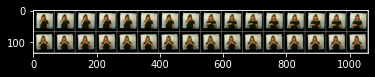

In [10]:
first_batch = next(iter(train_loader))[0]
plot_grid(first_batch)

### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 16, 2, 32, 32])
torch.Size([2, 32, 1, 16, 16])


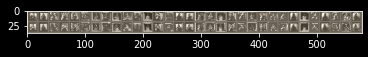

In [11]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(FRAMES_PER_SEGMENT*NUM_SEGMENTS, hidden_1, kernel_size=(2, 3, 3), stride=2, padding=1)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

print(x.shape)

x = conv2(x)
x = relu(x)
x = batch_2(x)

print(x.shape)


plot_grid(x, nrow=hidden_2)

## Check balance status of the loaders

In [12]:
from utils.balance import check_balance_status

print(check_balance_status(test_loader, classes))
print(check_balance_status(validation_loader, classes))
print(check_balance_status(train_loader, classes))


[('book', 5), ('candy', 2), ('chair', 2), ('clothes', 10), ('cousin', 6), ('drink', 5), ('go', 7), ('who', 1)]
[('before', 4), ('book', 3), ('candy', 2), ('chair', 2), ('clothes', 3), ('computer', 2), ('cousin', 4), ('drink', 3), ('go', 2), ('who', 1)]
[('before', 22), ('book', 18), ('candy', 20), ('chair', 22), ('clothes', 12), ('computer', 24), ('cousin', 13), ('drink', 18), ('go', 17), ('who', 23)]


In [13]:
# from lib.model import resnet34 as resnet

# model = resnet(sample_duration=FRAMES_PER_SEGMENT*NUM_SEGMENTS, sample_size=IMAGE_SIZE, num_classes=len(classes))
# model


In [14]:
from lib.simple_model import HPNet, CNNNet

Net = CNNNet

model = Net(
    num_classes=len(classes),
    batch_size=BATCH_SIZE,
    num_frames=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    image_size=int(IMAGE_SIZE * IMAGE_RANDOM_CROP_RESIZE),
    debug=DEBUG,
)

model


CNNNet(
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.15, inplace=False)
  (soft): LogSoftmax(dim=1)
  (conv1): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
  )
  (fc3): Sequential(
 

In [15]:
from lib.train import train_model


In [16]:
train_costs, val_costs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
)


Training on device: cuda
Train cost at epoch 1 is 2.32627
Validation cost at epoch 1 is 2.35228
Train cost at epoch 2 is 2.21122
Validation cost at epoch 2 is 2.28093
Train cost at epoch 3 is 2.12371
Validation cost at epoch 3 is 2.17180
Train cost at epoch 4 is 2.05104
Validation cost at epoch 4 is 2.23764
Train cost at epoch 5 is 1.95548
Validation cost at epoch 5 is 2.22434
Train cost at epoch 6 is 1.88718
Validation cost at epoch 6 is 2.18903
Train cost at epoch 7 is 1.81561
Validation cost at epoch 7 is 2.13697
Train cost at epoch 8 is 1.74750
Validation cost at epoch 8 is 2.12356
Train cost at epoch 9 is 1.68060
Validation cost at epoch 9 is 2.07828
Train cost at epoch 10 is 1.60186
Validation cost at epoch 10 is 2.07192


### Normalize costs between 0 and 1

In [17]:
from utils.output import plot_costs

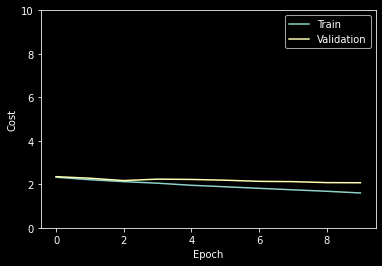

<Figure size 72x72 with 0 Axes>

In [18]:
plot_costs(train_costs, val_costs)


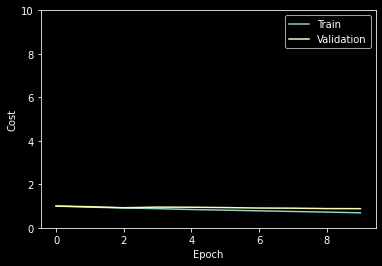

<Figure size 72x72 with 0 Axes>

In [19]:
# Normalized costs. Does not represent real cost values.
plot_costs(train_costs, val_costs, normalize_data=True)


In [20]:
from lib.test import check_accuracy


In [21]:
check_accuracy(train_loader, model, classes, device, n_batchs=10)


Predictions for batch 1 
['drink', 'before']
Ground truth for batch 1
['drink', 'cousin']
---------------------------------


Predictions for batch 2 
['drink', 'book']
Ground truth for batch 2
['drink', 'book']
---------------------------------


Predictions for batch 3 
['who', 'book']
Ground truth for batch 3
['who', 'book']
---------------------------------


Predictions for batch 4 
['chair', 'computer']
Ground truth for batch 4
['chair', 'computer']
---------------------------------


Predictions for batch 5 
['chair', 'drink']
Ground truth for batch 5
['chair', 'drink']
---------------------------------


Predictions for batch 6 
['drink', 'chair']
Ground truth for batch 6
['drink', 'chair']
---------------------------------


Predictions for batch 7 
['before', 'go']
Ground truth for batch 7
['before', 'before']
---------------------------------


Predictions for batch 8 
['clothes', 'who']
Ground truth for batch 8
['clothes', 'computer']
---------------------------------


Pre

In [22]:
check_accuracy(validation_loader, model, classes, device)

Predictions for batch 1 
['who', 'candy']
Ground truth for batch 1
['cousin', 'book']
---------------------------------


Predictions for batch 2 
['candy', 'before']
Ground truth for batch 2
['cousin', 'before']
---------------------------------


Predictions for batch 3 
['who', 'cousin']
Ground truth for batch 3
['drink', 'cousin']
---------------------------------


Predictions for batch 4 
['drink', 'who']
Ground truth for batch 4
['drink', 'before']
---------------------------------


Predictions for batch 5 
['who', 'clothes']
Ground truth for batch 5
['drink', 'clothes']
---------------------------------


Predictions for batch 6 
['computer', 'chair']
Ground truth for batch 6
['who', 'computer']
---------------------------------


Predictions for batch 7 
['go', 'computer']
Ground truth for batch 7
['go', 'before']
---------------------------------


Predictions for batch 8 
['computer', 'chair']
Ground truth for batch 8
['book', 'clothes']
---------------------------------




In [23]:
check_accuracy(test_loader, model, classes, device)

Predictions for batch 1 
['before', 'book']
Ground truth for batch 1
['clothes', 'clothes']
---------------------------------


Predictions for batch 2 
['before', 'drink']
Ground truth for batch 2
['who', 'chair']
---------------------------------


Predictions for batch 3 
['go', 'before']
Ground truth for batch 3
['go', 'book']
---------------------------------


Predictions for batch 4 
['go', 'who']
Ground truth for batch 4
['clothes', 'cousin']
---------------------------------


Predictions for batch 5 
['chair', 'candy']
Ground truth for batch 5
['go', 'book']
---------------------------------


Predictions for batch 6 
['computer', 'drink']
Ground truth for batch 6
['clothes', 'drink']
---------------------------------


Predictions for batch 7 
['book', 'book']
Ground truth for batch 7
['clothes', 'clothes']
---------------------------------


Predictions for batch 8 
['candy', 'computer']
Ground truth for batch 8
['drink', 'go']
---------------------------------


Prediction